In [1]:
import pandas as pd
from jcopml.plot import plot_missing_value

# Import Data

In [2]:
df = pd.read_csv("data/amazon_reviews.txt", delimiter="\t")
df.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


# Data Analysis

#### Melihat Jumlah baris atau banyaknya data 

In [3]:
len(df)

21000

#### Memastikan jumlah unique value pada kolom RATING

In [4]:
df["RATING"].unique()

array([4, 3, 1, 2, 5], dtype=int64)

#### Memastikan jumlah unique value pada kolom VERIFIED_PURCHASE

In [5]:
df["VERIFIED_PURCHASE"].unique()

array(['N', 'Y'], dtype=object)

In [6]:
df["REVIEW_TITLE"].unique()

array(['useful', 'New era for batteries', "doesn't swing very well.", ...,
       'I love moccasins This fit like it was custom made for ...',
       'This fit well, comfortable, best investment',
       'Love these shoes, except for the laces'], dtype=object)

#### Memastikan bahwa tidak ada data yang kosong

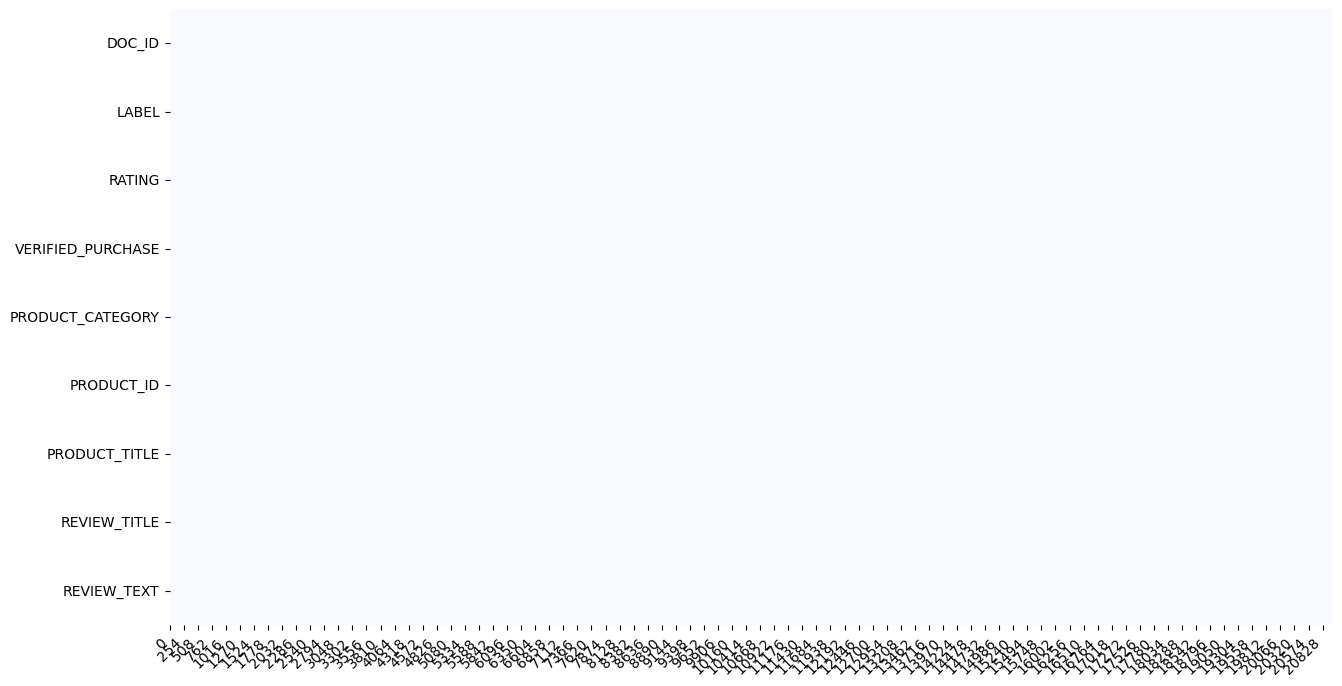

In [7]:
plot_missing_value(df=df)

## KESIMPULAN

- Terdapat 5 unique value pada kolom RATING
- Terdapat 2 unique value pada kolom VERIFIED_PURCHASED
- tidak ada kolom yang memiliki data kosong

## Kolom yang dapat digunakan untuk tahap modeling
`RATING, VERIFIED_PURCHASE, REVIEW_TITLE, dan REVIEW TEXT`

# PEMILIHAN FITUR (KOLOM)

In [8]:
fitur = ["RATING", "VERIFIED_PURCHASE", "REVIEW_TITLE", "REVIEW_TEXT"]
df = df[fitur]

# Konversi value dari kolom VERIFIED_PURCHASE ke biner
df["VERIFIED_PURCHASE"] = df["VERIFIED_PURCHASE"].map({"Y" : 1, "N" : 1})
df.head()

,RATING,VERIFIED_PURCHASE,REVIEW_TITLE,REVIEW_TEXT
0,4,1,useful,"When least you think so, this product will sav..."
1,4,1,New era for batteries,Lithium batteries are something new introduced...
2,3,1,doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,1,Great computing!,I was looking for an inexpensive desk calcolat...
4,4,1,Only use twice a week,I only use it twice a week and the results are...


# TEXT-PREPROCESSING

#### PERSIAPAN MELAKUKAN TEXT-PREPROCESSING

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from scipy.sparse import csr_matrix
import re

In [10]:
def remove_emojis(text):
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoji, '', text)

In [11]:
def preprocess_text(text):
    # Hapus emoji
    text = remove_emojis(text)
    
    # Case folding
    text = text.lower()

    # Hapus tanda baca/angka
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenisasi
    tokens = word_tokenize(text)
    
    # Stopword removal + Penghapusan tanda baca
    sw_english = stopwords.words("english") + list(punctuation)
    tokens = [word for word in tokens if word not in sw_english]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)  # Gabungkan kembali menjadi teks

#### Penggabungan kolom REVIEW_TITLE dan REVIEW_TEXT

In [12]:
df["COMBINED_TEXT"] = df["REVIEW_TITLE"] + " " + df["REVIEW_TEXT"]
df.head()

,RATING,VERIFIED_PURCHASE,REVIEW_TITLE,REVIEW_TEXT,COMBINED_TEXT
0,4,1,useful,"When least you think so, this product will sav...","useful When least you think so, this product w..."
1,4,1,New era for batteries,Lithium batteries are something new introduced...,New era for batteries Lithium batteries are so...
2,3,1,doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,doesn't swing very well. I purchased this swin...
3,4,1,Great computing!,I was looking for an inexpensive desk calcolat...,Great computing! I was looking for an inexpens...
4,4,1,Only use twice a week,I only use it twice a week and the results are...,Only use twice a week I only use it twice a we...


#### PENERAPAN TEXT PREPROCESSING

In [13]:
df["TOKENS"] = df["COMBINED_TEXT"].apply(preprocess_text)
df.head()

,RATING,VERIFIED_PURCHASE,REVIEW_TITLE,REVIEW_TEXT,COMBINED_TEXT,TOKENS
0,4,1,useful,"When least you think so, this product will sav...","useful When least you think so, this product w...",useful least think product save day keep aroun...
1,4,1,New era for batteries,Lithium batteries are something new introduced...,New era for batteries Lithium batteries are so...,new era battery lithium battery something new ...
2,3,1,doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,doesn't swing very well. I purchased this swin...,doesnt swing well purchased swing baby 6 month...
3,4,1,Great computing!,I was looking for an inexpensive desk calcolat...,Great computing! I was looking for an inexpens...,great computing looking inexpensive desk calco...
4,4,1,Only use twice a week,I only use it twice a week and the results are...,Only use twice a week I only use it twice a we...,use twice week use twice week result great use...


#### Memastikan bahwa tidak ada kolom yang kosong dikarenakan preprocessing text

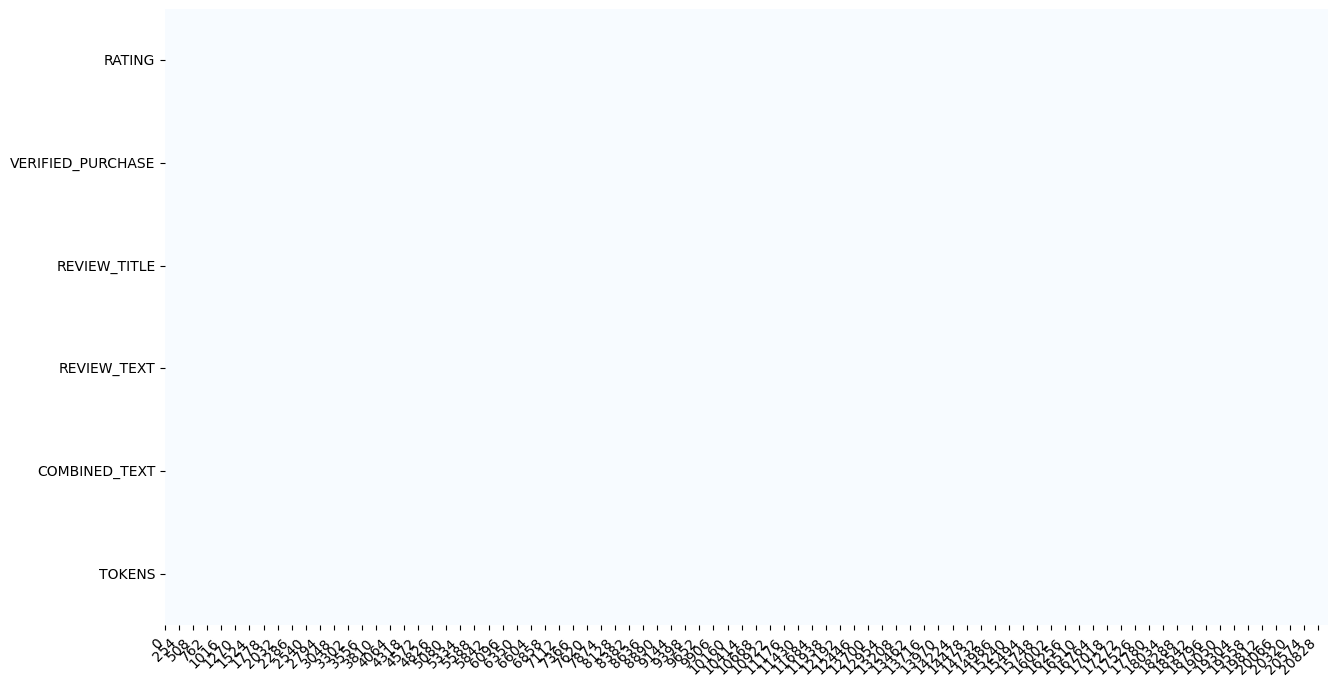

In [14]:
plot_missing_value(df=df)

In [15]:
df.iloc[0]["COMBINED_TEXT"]

'useful When least you think so, this product will save the day. Just keep it around just in case you need it for something.'

In [16]:
df.iloc[0]["TOKENS"]

'useful least think product save day keep around case need something'

#### ANALISIS SENTIMENT MENGGUNAKAN TEXTBLOB

In [17]:
df.head()

,RATING,VERIFIED_PURCHASE,REVIEW_TITLE,REVIEW_TEXT,COMBINED_TEXT,TOKENS
0,4,1,useful,"When least you think so, this product will sav...","useful When least you think so, this product w...",useful least think product save day keep aroun...
1,4,1,New era for batteries,Lithium batteries are something new introduced...,New era for batteries Lithium batteries are so...,new era battery lithium battery something new ...
2,3,1,doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,doesn't swing very well. I purchased this swin...,doesnt swing well purchased swing baby 6 month...
3,4,1,Great computing!,I was looking for an inexpensive desk calcolat...,Great computing! I was looking for an inexpens...,great computing looking inexpensive desk calco...
4,4,1,Only use twice a week,I only use it twice a week and the results are...,Only use twice a week I only use it twice a we...,use twice week use twice week result great use...


In [18]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return "positif"
    elif polarity < 0:
        return "negatif"
    else:
        return "netral"

In [19]:
df["LABEL"] = df["TOKENS"].apply(analyze_sentiment)
df.head()

,RATING,VERIFIED_PURCHASE,REVIEW_TITLE,REVIEW_TEXT,COMBINED_TEXT,TOKENS,LABEL
0,4,1,useful,"When least you think so, this product will sav...","useful When least you think so, this product w...",useful least think product save day keep aroun...,netral
1,4,1,New era for batteries,Lithium batteries are something new introduced...,New era for batteries Lithium batteries are so...,new era battery lithium battery something new ...,positif
2,3,1,doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,doesn't swing very well. I purchased this swin...,doesnt swing well purchased swing baby 6 month...,positif
3,4,1,Great computing!,I was looking for an inexpensive desk calcolat...,Great computing! I was looking for an inexpens...,great computing looking inexpensive desk calco...,positif
4,4,1,Only use twice a week,I only use it twice a week and the results are...,Only use twice a week I only use it twice a we...,use twice week use twice week result great use...,positif


In [20]:
df["LABEL"].value_counts()

LABEL
positif    18648
negatif     2055
netral       297
Name: count, dtype: int64

#### MEMBUANG KOLOM YANG TIDAK DI GUNAKAN

In [21]:
df.drop(columns=["REVIEW_TITLE", "REVIEW_TEXT", "COMBINED_TEXT"], inplace=True)
df.head()

,RATING,VERIFIED_PURCHASE,TOKENS,LABEL
0,4,1,useful least think product save day keep aroun...,netral
1,4,1,new era battery lithium battery something new ...,positif
2,3,1,doesnt swing well purchased swing baby 6 month...,positif
3,4,1,great computing looking inexpensive desk calco...,positif
4,4,1,use twice week use twice week result great use...,positif


#### FEATURE EXTRACTION

In [22]:
tfidf = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    stop_words=None,
    use_idf=True,
    max_features=1400
)

X_tfidf = tfidf.fit_transform(df["TOKENS"])

In [23]:
print(X_tfidf.shape)

(21000, 1400)


In [25]:
tfidf_df = pd.DataFrame.sparse.from_spmatrix(
    X_tfidf,
    columns=tfidf.get_feature_names_out()  
)

final_df = pd.concat([
    df[['RATING', 'VERIFIED_PURCHASE']],  
    tfidf_df,                             
    df['LABEL']
], axis=1)

final_df.head()

,RATING,VERIFIED_PURCHASE,10,100,12,13,14,15,20,25,...,year,yellow,yes,yet,youll,young,youre,zipper,zoom,LABEL
0,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,netral
1,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positif
2,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positif
3,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positif
4,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positif


In [26]:
final_df.to_csv(path_or_buf="data/sentiment_amazon.csv", index=False)